In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

In [95]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [4]:
spark.read.csv("MsCustomer.csv",header=True).createOrReplaceTempView("Customer")
spark.read.csv("MsDriver.csv",header=True).createOrReplaceTempView("Driver")
spark.read.csv("MsFood.csv",header=True).createOrReplaceTempView("Food")
spark.read.csv("MsRestaurant.csv",header=True).createOrReplaceTempView("Restaurant")
spark.read.csv("TransactionDetail.csv",header=True).createOrReplaceTempView("TransactionDetails")
spark.read.csv("TransactionHeader.csv",header=True).createOrReplaceTempView("TransactionHeaders")

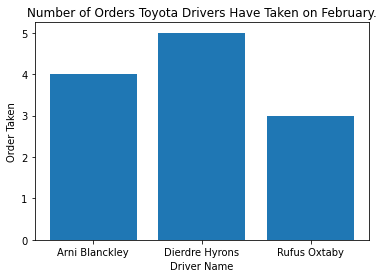

In [107]:
data = spark.sql("""
select drivername, count(th.transactionid) as count 
from Driver d JOIN
transactionheaders th ON th.driverid = d.driverid 
where d.drivervehicle = "Toyota" and 
month(transactiondate)="02"
group by drivername
""").toPandas()

plt.bar(data["drivername"], data["count"])
plt.title("Number of Orders Toyota Drivers Have Taken on February.")
plt.xlabel("Driver Name")
plt.ylabel("Order Taken")
plt.show()

<function matplotlib.pyplot.show>

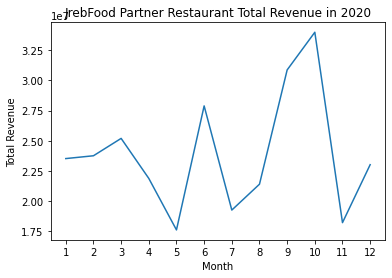

In [108]:
data = spark.sql("""
select sum(foodprice*quantity) as revenue, month(transactiondate) as month from restaurant r JOIN
transactionheaders th ON th.restaurantid = r.restaurantid JOIN
transactiondetails td ON td.transactionid=th.transactionid JOIN
food f ON f.foodid = td.foodid
where year(transactiondate)=2020 and
ispartner is True
group by month
order by month
""").toPandas()

plt.plot(data["month"], data["revenue"])
plt.title("JrebFood Partner Restaurant Total Revenue in 2020")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.show

<function matplotlib.pyplot.show>

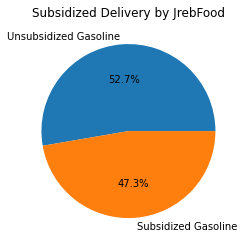

In [111]:
data = spark.sql("""
select count(*)as count, rata from
(
  select
  case
  when distance > average then 'Subsidized Gasoline'
  when distance <= average then 'Unsubsidized Gasoline'
  end as rata
  from
(
  select avg(distance) as average, month(transactiondate) as month
  from driver d,transactionheaders th 
  where th.driverid = d.driverid
  and month(transactiondate)= "01"
  group by month
) as x,transactionheaders th, driver d 
where d.driverid = th.driverid
)
group by rata
""").toPandas()

plt.pie(data["count"],labels=data["rata"],autopct="%.1f%%")
plt.title("Subsidized Delivery by JrebFood")
plt.show

In [97]:
# load data
training = spark.read.csv("Storm_Training.csv", header=True, inferSchema=True)
testing = spark.read.csv("Storm_Testing.csv", header=True, inferSchema=True)

#select features
columns = ["visible_cloud", "wind_direction", "temperature", "storm_coming"]
testing = testing.select(columns)
training = training.select(columns)

# data preprocessing (remove missing values)
training = training.na.drop()
testing = testing.na.drop()

#transform data
from pyspark.sql.functions import when 

def transform(data):
  data = data.withColumn(
      "visible_cloud",
      when(data["visible_cloud"] == "Cumulus", 0).
      when(data["visible_cloud"] == "Stratus", 1).
      when(data["visible_cloud"] == "Cumulonimbus", 2).
      when(data["visible_cloud"] == "Cirrus", 3)
  )

  data = data.withColumn(
      "temperature",
      when(data["temperature"] == "Decline", 0).
      when(data["temperature"] == "Stable", 1).
      otherwise(2)
  )

  data = data.withColumn(
      "wind_direction",
      when(data["wind_direction"] == "East", 0).
      when(data["wind_direction"] == "North", 1).
      when(data["wind_direction"] == "West", 2).
      otherwise(3)
  )

  data = data.withColumn(
      "storm_coming",
      when(data["storm_coming"] == "Yes", 0).
      otherwise(1)
  )

  return data

testing = transform(testing)
training = transform(training)

#normalization
from pyspark.ml.feature import VectorAssembler, StandardScaler

columns.remove("storm_coming")
assembler = VectorAssembler(inputCols=columns, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")

training = assembler.transform(training)
testing = assembler.transform(testing)

training = scaler.fit(training).transform(training)
testing = scaler.fit(testing).transform(testing)


#generate model
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(labelCol="storm_coming",maxIter=100).fit(training)
prediction = model.transform(testing)

#evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="storm_coming")

print("Accuracy: {}%". format(evaluator.evaluate(prediction) * 100))

Accuracy: 78.90863928913777%
